## Handwritten digit recognition

We have images of handwritten digits ranging from 0-9 written by various people in boxes of a specific size - similar to the application forms in banks and universities. The goal is to develop a model that can correctly identify the digit (between 0-9) written in an image. 

## Objective

We are required to develop a model using Support Vector Machine which should correctly classify the handwritten digits from 0-9 based on the pixel values given as features. Thus, this is a 10-class classification problem. 

### Data Description
For this problem, we use the MNIST data which is a large database of handwritten digits. The 'pixel values' of each digit (image) comprise the features, and the actual number between 0-9 is the label. 

Since each image is of 28 x 28 pixels, and each pixel forms a feature, there are 784 features. MNIST digit recognition is a well-studied problem in the ML community, and people have trained numerous models (Neural Networks, SVMs, boosted trees etc.) achieving error rates as low as 0.23% (i.e. accuracy = 99.77%, with a convolutional neural network).

In this assignment, try experimenting with various hyperparameters in SVMs and observe the highest accuracy you can get. With a sub-sample of 10-20% of the training data (see note below), you should expect to get an accuracy of more than 90%.

Important Note:

Since the training dataset is quite large (42,000 labelled images), it would take a lot of time for training an SVM on the full MNIST data, so you can sub-sample the data for training (10-20% of the data should be enough to achieve decent accuracy). Also, running a GridSearchCV() may take hours if you use a large value of k (fold-CV) such as 10 and a wide range of hyperparameters; k = 5 should be sufficient.

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

# train dataset
letters = pd.read_csv("train.csv")

# test dataset
letters_test = pd.read_csv("test.csv")

In [2]:
#Dividing our data in train and test
train, test = train_test_split(letters, train_size=0.2, test_size=0.1, random_state=4)

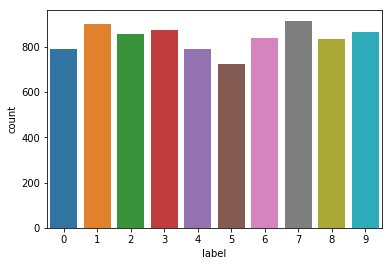

In [3]:
# Check if train df is biased or not to particular digit
sns.countplot(train['label'])
plt.show()

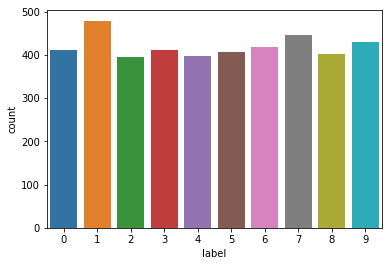

In [4]:
# Check if test df is biased or not to particular digit
sns.countplot(test['label'])
plt.show()

In [5]:
# about the dataset

# dimensions
print("Dimensions: ", train.shape, "\n")

# data types
print(train.info())

# head
train.head()

Dimensions:  (8400, 785) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8400 entries, 12696 to 33472
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 50.7 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
12696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4362,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3847,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38550,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32222,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#Checking test df
letters_test.shape

(28000, 784)

In [9]:
print(train.columns)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


In [10]:
#Checking if there are any Duplicate rows
print(train['label'].nunique())

#1460 unique rows are present

10


In [11]:
#let's look at the statistical aspects of the dataframe
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,8400.000000,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,...,8400.000000,8400.000000,8400.000000,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0,8400.0
mean,4.520000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.187262,0.084524,0.012262,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.891222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.544444,3.933244,1.000163,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,91.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#checking type of each column
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8400 entries, 12696 to 33472
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 50.7 MB


In [12]:
#Checking digits in label column
order = list(np.sort(train['label'].unique()))
print(order)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [13]:
letter_means = train.groupby('label').mean()
letter_means.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


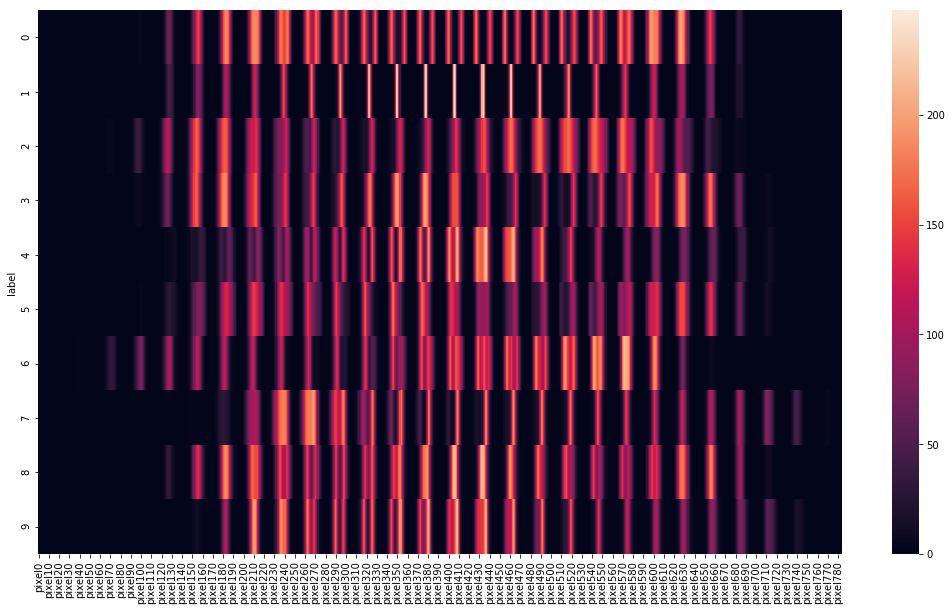

In [14]:
plt.figure(figsize=(18, 10))
sns.heatmap(letter_means)

In [15]:
# List train df column
list(train)

['label',
 'pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8',
 'pixel9',
 'pixel10',
 'pixel11',
 'pixel12',
 'pixel13',
 'pixel14',
 'pixel15',
 'pixel16',
 'pixel17',
 'pixel18',
 'pixel19',
 'pixel20',
 'pixel21',
 'pixel22',
 'pixel23',
 'pixel24',
 'pixel25',
 'pixel26',
 'pixel27',
 'pixel28',
 'pixel29',
 'pixel30',
 'pixel31',
 'pixel32',
 'pixel33',
 'pixel34',
 'pixel35',
 'pixel36',
 'pixel37',
 'pixel38',
 'pixel39',
 'pixel40',
 'pixel41',
 'pixel42',
 'pixel43',
 'pixel44',
 'pixel45',
 'pixel46',
 'pixel47',
 'pixel48',
 'pixel49',
 'pixel50',
 'pixel51',
 'pixel52',
 'pixel53',
 'pixel54',
 'pixel55',
 'pixel56',
 'pixel57',
 'pixel58',
 'pixel59',
 'pixel60',
 'pixel61',
 'pixel62',
 'pixel63',
 'pixel64',
 'pixel65',
 'pixel66',
 'pixel67',
 'pixel68',
 'pixel69',
 'pixel70',
 'pixel71',
 'pixel72',
 'pixel73',
 'pixel74',
 'pixel75',
 'pixel76',
 'pixel77',
 'pixel78',
 'pixel79',
 'pixel80',
 'pixel81',
 'pixel82',
 'pi

In [16]:
# Checking each attribute for each column of train df
col = list(train)

for i in col:
    print(train[i].astype('category').value_counts())

7    916
1    902
3    873
9    867
2    856
6    839
8    836
0    793
4    792
5    726
Name: label, dtype: int64
0    8400
Name: pixel0, dtype: int64
0    8400
Name: pixel1, dtype: int64
0    8400
Name: pixel2, dtype: int64
0    8400
Name: pixel3, dtype: int64
0    8400
Name: pixel4, dtype: int64
0    8400
Name: pixel5, dtype: int64
0    8400
Name: pixel6, dtype: int64
0    8400
Name: pixel7, dtype: int64
0    8400
Name: pixel8, dtype: int64
0    8400
Name: pixel9, dtype: int64
0    8400
Name: pixel10, dtype: int64
0    8400
Name: pixel11, dtype: int64
0     8399
10       1
Name: pixel12, dtype: int64
0      8399
216       1
Name: pixel13, dtype: int64
0      8399
216       1
Name: pixel14, dtype: int64
0    8399
9       1
Name: pixel15, dtype: int64
0    8400
Name: pixel16, dtype: int64
0    8400
Name: pixel17, dtype: int64
0    8400
Name: pixel18, dtype: int64
0    8400
Name: pixel19, dtype: int64
0    8400
Name: pixel20, dtype: int64
0    8400
Name: pixel21, dtype: int64
0    840

Name: pixel73, Length: 117, dtype: int64
0      8244
254       9
253       9
255       7
236       3
125       3
226       3
79        3
21        3
42        3
139       2
44        2
146       2
128       2
113       2
91        2
64        2
47        2
37        2
43        2
180       2
35        2
18        2
15        2
14        2
9         2
5         2
1         2
148       2
145       2
       ... 
187       1
177       1
174       1
171       1
170       1
168       1
167       1
166       1
163       1
160       1
159       1
156       1
153       1
151       1
149       1
189       1
245       1
142       1
237       1
138       1
132       1
129       1
191       1
120       1
118       1
194       1
111       1
102       1
195       1
239       1
Name: pixel74, Length: 98, dtype: int64
0      8296
255      11
253       7
254       4
15        2
103       2
130       2
72        2
58        2
156       2
170       2
179       2
31        2
185       2
211       2
10     

0      6735
253     186
254     119
255      86
252      60
13       22
7        17
64       15
128      15
2        13
10       12
233      12
191      12
25       12
5        12
22       11
1        11
31       11
37       10
236      10
38       10
3        10
36       10
23       10
212       9
113       9
16        9
138       9
9         9
226       9
       ... 
129       2
94        2
89        2
54        2
65        2
68        2
69        2
75        2
103       2
100       2
98        2
247       1
221       1
217       1
72        1
192       1
190       1
135       1
93        1
123       1
165       1
108       1
160       1
155       1
111       1
51        1
145       1
119       1
140       1
146       1
Name: pixel130, Length: 253, dtype: int64
0      7152
253     122
254      77
255      70
252      29
7        18
3        15
4        15
191      12
128      12
29       11
31       11
141      10
124      10
28        9
64        8
136       8
79        8
72        

Name: pixel188, Length: 255, dtype: int64
0      6560
253     218
254     106
252     101
255      52
9        16
132      15
128      15
25       15
10       14
64       14
250      13
32       13
1        12
19       12
21       12
244      11
3        11
16       11
36       11
111      11
2        11
191      10
17       10
22       10
56       10
5        10
51       10
76       10
249      10
       ... 
153       2
75        2
145       2
99        2
237       2
52        2
133       2
113       2
129       2
242       2
121       2
14        1
239       1
201       1
80        1
181       1
195       1
88        1
192       1
182       1
120       1
178       1
94        1
71        1
149       1
144       1
107       1
109       1
126       1
125       1
Name: pixel189, Length: 256, dtype: int64
0      7249
253     106
254      61
252      57
255      20
128      17
7        14
10       14
19       14
13       12
1        11
64       11
5        10
246      10
251       9
17  

Name: pixel243, Length: 256, dtype: int64
0      4736
253     689
252     296
254     267
255     119
251      37
128      30
250      25
64       24
235      22
63       22
245      22
170      21
9        20
233      18
10       18
222      18
7        17
190      17
225      17
4        17
246      17
203      16
234      16
240      16
40       16
191      16
236      16
21       16
168      16
       ... 
119       4
142       4
120       4
163       4
212       4
199       4
58        4
103       4
95        4
186       4
73        4
80        4
105       3
148       3
67        3
72        3
143       3
182       3
183       3
184       3
90        3
117       3
115       3
44        2
45        2
165       2
123       2
54        2
171       1
155       1
Name: pixel244, Length: 256, dtype: int64
0      5763
253     410
252     211
254     153
255      75
251      38
64       26
128      25
18       20
250      19
191      19
12       18
16       16
36       16
63       16
170 

Name: pixel290, Length: 256, dtype: int64
0      3574
253     838
254     449
252     404
255     173
251      86
247      37
250      33
244      31
191      30
128      30
245      30
249      27
236      25
84       25
10       25
241      24
240      24
246      24
9        24
239      23
21       23
242      23
6        22
11       22
17       22
226      22
231      22
233      22
85       21
       ... 
145       5
74        5
81        5
62        5
94        5
66        5
124       5
77        5
142       5
117       5
53        5
113       5
60        5
89        4
143       4
121       4
152       4
135       4
92        4
83        3
129       3
173       3
98        3
166       3
164       3
115       3
90        2
107       2
150       2
104       2
Name: pixel291, Length: 256, dtype: int64
0      3849
253     715
254     384
252     337
255     138
251      74
191      34
128      34
9        32
3        28
64       28
31       28
244      27
4        26
14       26
234 

Name: pixel344, Length: 256, dtype: int64
0      4193
253     809
254     450
252     309
255     137
251      66
248      27
128      26
7        23
191      22
250      21
230      21
231      21
226      21
243      21
242      21
236      20
246      19
245      19
4        19
19       18
29       18
225      18
247      17
222      17
86       17
10       17
241      17
82       16
32       16
       ... 
187       5
109       5
103       5
92        5
221       4
83        4
207       4
87        4
142       4
132       4
101       4
96        4
94        4
93        4
37        4
91        4
69        4
60        4
48        4
166       3
88        3
185       3
67        3
194       3
118       3
120       3
44        3
148       3
167       3
144       2
Name: pixel345, Length: 256, dtype: int64
0      3889
253     875
254     463
252     320
255     157
251      52
250      38
128      30
222      29
191      29
243      28
247      23
248      22
229      22
234      21
20  

Name: pixel403, Length: 256, dtype: int64
0      3684
253     767
254     470
252     372
255     130
251      51
128      47
250      37
64       32
57       29
22       25
21       23
13       23
19       23
240      22
51       22
234      22
38       22
246      21
9        21
191      20
241      20
5        20
59       20
248      19
147      19
244      19
230      19
3        19
6        19
       ... 
105       6
90        6
143       6
172       6
28        6
201       6
131       6
135       6
137       6
200       6
134       5
52        5
101       5
99        5
179       5
23        5
87        5
173       5
39        4
67        4
130       4
96        4
121       4
117       4
192       4
165       4
182       3
148       3
61        2
75        1
Name: pixel404, Length: 256, dtype: int64
0      3211
253    1013
254     598
252     400
255     180
251      59
128      52
233      32
234      30
250      28
248      28
243      27
247      25
29       25
246      25
63  

Name: pixel460, Length: 256, dtype: int64
0      3333
253     947
254     620
252     467
255     197
251      89
128      40
233      33
247      32
250      30
248      28
244      28
237      28
231      27
246      26
245      25
7        23
232      22
13       21
249      21
230      21
198      21
236      20
239      20
240      20
24       20
224      20
191      20
64       19
10       19
       ... 
45        6
115       5
133       5
119       5
101       5
105       5
134       5
103       5
163       5
46        5
174       5
149       4
80        4
106       4
75        4
1         4
89        4
172       4
173       4
153       4
113       4
54        4
30        4
52        4
90        4
123       3
182       3
126       3
67        2
39        1
Name: pixel461, Length: 256, dtype: int64
0      2922
253    1110
254     698
252     463
255     260
251      82
250      33
248      32
128      31
234      26
246      25
230      25
191      24
233      24
231      24
228 

Name: pixel506, dtype: int64
0      8303
253       7
255       5
3         4
34        2
25        2
153       2
145       2
51        2
179       2
27        2
64        2
67        2
74        2
18        2
13        2
254       2
41        2
71        1
46        1
76        1
54        1
47        1
79        1
86        1
250       1
40        1
101       1
32        1
30        1
       ... 
176       1
234       1
226       1
223       1
221       1
220       1
219       1
217       1
216       1
215       1
210       1
208       1
191       1
187       1
170       1
237       1
158       1
157       1
148       1
147       1
143       1
138       1
133       1
130       1
128       1
127       1
123       1
117       1
109       1
113       1
Name: pixel507, Length: 71, dtype: int64
0      8006
253      35
254      22
255      20
252      11
10        9
191       9
7         6
32        6
96        6
112       5
128       5
192       4
63        4
73        4
113       4
125   

Name: pixel554, Length: 239, dtype: int64
0      7820
253      48
254      22
252      22
255      14
7         9
13        8
6         6
10        6
28        6
128       6
2         6
50        5
122       5
84        5
168       5
250       5
64        5
245       5
42        5
206       4
190       4
205       4
17        4
45        4
8         4
14        4
196       4
114       4
234       4
       ... 
165       1
161       1
74        1
159       1
79        1
82        1
86        1
92        1
94        1
100       1
102       1
106       1
107       1
110       1
118       1
249       1
126       1
130       1
132       1
135       1
138       1
146       1
149       1
150       1
152       1
153       1
155       1
157       1
158       1
127       1
Name: pixel555, Length: 203, dtype: int64
0      8152
253      16
254      11
5         6
7         5
48        5
255       5
4         4
170       4
46        4
42        3
23        3
90        3
75        3
63        3
56  

Name: pixel603, Length: 256, dtype: int64
0      3173
253     958
254     466
252     445
255     181
251      81
128      43
249      36
247      35
191      33
250      31
244      30
239      29
245      27
233      27
5        26
64       26
241      25
243      24
248      24
223      23
220      23
203      23
15       23
41       22
9        22
231      21
32       21
12       21
240      21
       ... 
134       6
74        6
155       6
190       6
90        6
118       6
117       6
67        6
157       6
150       6
107       6
98        6
75        6
138       6
151       6
182       5
167       5
148       5
152       5
80        5
48        5
88        5
33        4
188       4
58        4
1         4
101       4
79        3
200       3
120       2
Name: pixel604, Length: 256, dtype: int64
0      3984
253     757
252     365
254     343
255     139
251      91
250      40
128      39
64       30
245      28
141      26
191      25
240      25
248      25
40       23
244 

Name: pixel663, Length: 226, dtype: int64
0      7907
253      44
252      20
254      18
255      11
2         9
3         9
12        8
28        7
7         6
20        6
24        6
11        6
128       6
19        6
38        5
41        5
241       5
42        5
126       5
1         5
250       5
18        4
56        4
64        4
15        4
17        4
75        4
225       4
226       4
       ... 
165       1
122       1
121       1
114       1
88        1
72        1
194       1
77        1
79        1
173       1
81        1
82        1
83        1
193       1
85        1
86        1
89        1
112       1
90        1
92        1
191       1
98        1
100       1
102       1
103       1
190       1
188       1
106       1
187       1
119       1
Name: pixel664, Length: 190, dtype: int64
0      8150
253      25
252       8
254       6
8         6
255       6
13        4
1         4
17        4
245       3
53        3
32        3
31        3
24        3
100       3
19  

Name: pixel734, dtype: int64
0      8322
253       8
252       5
7         3
115       2
31        2
119       2
240       2
107       2
164       2
87        1
84        1
83        1
69        1
64        1
49        1
48        1
37        1
28        1
29        1
100       1
26        1
19        1
16        1
15        1
14        1
13        1
11        1
6         1
4         1
3         1
1         1
96        1
254       1
101       1
104       1
248       1
242       1
238       1
236       1
231       1
228       1
221       1
215       1
214       1
209       1
205       1
202       1
199       1
194       1
176       1
157       1
151       1
146       1
138       1
137       1
136       1
122       1
114       1
111       1
Name: pixel735, dtype: int64
0      8284
253      13
252       7
254       3
32        3
89        3
255       3
128       2
210       2
37        2
156       2
53        2
25        2
72        2
62        2
221       2
102       2
228       2
169   

In [17]:
#Checking if any column name containg space
train.columns[train.columns.str.contains(' ')]

Index([], dtype='object')

In [18]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
12696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4362,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3847,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38550,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32222,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Preparation

Let's conduct some data preparation steps before modeling. Firstly, let's see if it is important to **rescale** the features, since they may have varying ranges. For example, here are the average values:

In [19]:
# splitting into X and y
X = train.drop("label", axis = 1)
y = train['label']

In [20]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
12696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# scaling the features
X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


In [22]:
# Shape of X_train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6720, 784)
(1680, 784)
(6720,)
(1680,)


In [23]:
#Data Preparation for test data
# test dataset
Xtest = letters_test

In [24]:
print(Xtest.shape)

(28000, 784)


In [25]:
# scaling the features
Xtest_scaled = scale(Xtest)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


In [26]:
# Creating sample_submission df
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


## Model Building

Let's fist build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

In [27]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)

In [28]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# Confusion matrix
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9089285714285714 

[[159   0   0   1   1   0   0   0   0   0]
 [  0 149   0   1   0   0   0   0   0   0]
 [  1   4 159   6   3   1   2   4   1   1]
 [  1   0   3 147   1   5   1   2   1   2]
 [  0   0   1   0 175   0   3   1   1   6]
 [  0   4   3  11   1 141   1   0   5   2]
 [  3   0   3   1   1   1 156   0   0   0]
 [  1   2   1   2   3   0   1 174   0   2]
 [  4   2   1  11   1   4   1   1 130   0]
 [  1   1   3   2   9   1   0   8   1 137]]


The linear model gives approx. ~91% accuracy. Let's look at a sufficiently non-linear model with randomly chosen hyperparameters.

In [29]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [30]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# metrics
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.930952380952381 

[[156   0   2   1   1   0   0   0   1   0]
 [  0 148   1   1   0   0   0   0   0   0]
 [  2   1 171   2   3   0   0   0   2   1]
 [  0   0   6 149   1   1   0   4   1   1]
 [  0   0   1   0 178   0   2   3   0   3]
 [  0   1   2   8   0 153   1   0   3   0]
 [  2   0   3   0   0   1 159   0   0   0]
 [  1   2   4   2   2   0   0 169   0   6]
 [  1   0   2   3   1   5   2   0 140   1]
 [  1   0   5   3   6   0   0   5   2 141]]


The non-linear model gives approx. 93% accuracy. Thus, going forward, let's choose hyperparameters corresponding to non-linear models.

## Grid Search: Hyperparameter Tuning

Let's now tune the model to find the optimal values of C and gamma corresponding to an RBF kernel. We'll use 5-fold cross validation.

In [31]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True, n_jobs=-1)      

# fit the model
model_cv.fit(X_train, y_train)                  

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 17.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [32]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,59.723731,2.372507,7.416712,0.599316,1,0.01,"{'C': 1, 'gamma': 0.01}",0.735863,0.724702,0.744792,...,0.730357,0.011770,12,0.999814,0.999814,0.999814,1.000000,0.999628,0.999814,0.000118
1,15.485977,1.616388,4.626777,0.610353,1,0.001,"{'C': 1, 'gamma': 0.001}",0.929315,0.936756,0.930060,...,0.930060,0.004261,4,0.974144,0.974144,0.973400,0.975632,0.974702,0.974405,0.000740
2,26.634262,1.044332,7.253388,1.178891,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.898065,0.904762,0.883929,...,0.897917,0.007402,8,0.911272,0.909598,0.910714,0.912388,0.909412,0.910677,0.001100
3,77.650792,1.095256,9.933462,0.793171,10,0.01,"{'C': 10, 'gamma': 0.01}",0.752232,0.738839,0.764137,...,0.750149,0.008871,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,16.146501,3.242476,5.022945,0.705124,10,0.001,"{'C': 10, 'gamma': 0.001}",0.937500,0.940476,0.940476,...,0.937946,0.003753,1,0.999070,0.999256,0.999442,0.999814,0.999442,0.999405,0.000247
5,14.799405,1.690863,5.421111,0.588486,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.925595,0.931548,0.926339,...,0.928125,0.002517,5,0.961310,0.964844,0.963728,0.964658,0.962798,0.963467,0.001303
6,73.415180,3.767030,9.168546,1.623121,100,0.01,"{'C': 100, 'gamma': 0.01}",0.752232,0.738839,0.764137,...,0.750149,0.008871,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,14.407109,1.301907,5.627716,1.504772,100,0.001,"{'C': 100, 'gamma': 0.001}",0.936756,0.943452,0.938244,...,0.937500,0.004048,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,11.166434,1.277216,4.401901,0.485613,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.924851,0.924107,0.922619,...,0.923214,0.001280,6,0.994606,0.995908,0.994792,0.995536,0.995164,0.995201,0.000476
9,72.105329,1.720368,10.466674,0.516336,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.752232,0.738839,0.764137,...,0.750149,0.008871,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


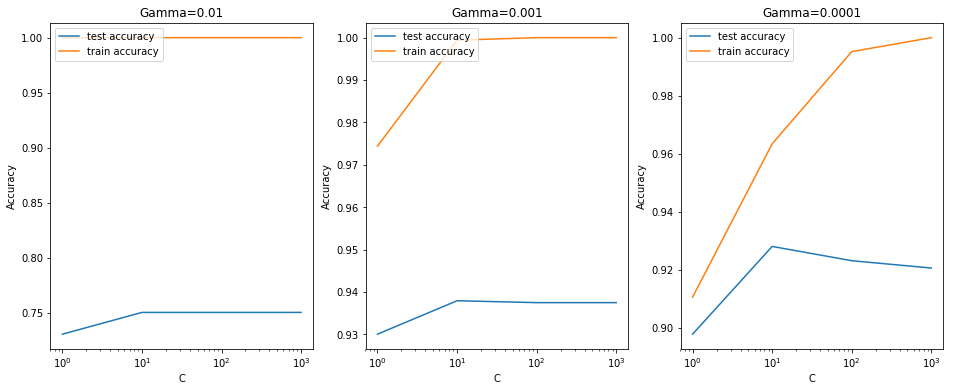

In [33]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
#plt.ylim([0.60, 1.5])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
#plt.ylim([0.60, 1.5])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
#plt.ylim([0.60, 1.5])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

The plots above show some useful insights:
- Non-linear models (high gamma) perform *much better* than the linear ones
- At any value of gamma, a high value of C leads to better performance
- None of the models tend to overfit (even the complex ones), since the training and test accuracies closely follow each other

This suggests that the problem and the data is **inherently non-linear** in nature, and a complex model will outperform simple, linear models in this case.

Let's now choose the best hyperparameters. 

In [34]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9379464285714286 corresponding to hyperparameters {'C': 10, 'gamma': 0.001}


The best test score is 0.935204081632653 corresponding to hyperparameters {'C': 10, 'gamma': 0.001}

### Building and Evaluating the Final Model

Let's now build and evaluate the final model, i.e. the model with highest test accuracy.

In [35]:
# model with optimal hyperparameters

# model
model = SVC(C=10, gamma=0.001, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred), "\n")
print(metrics.confusion_matrix(y_test, y_pred), "\n")

accuracy 0.9428571428571428 

[[158   0   1   1   1   0   0   0   0   0]
 [  0 148   1   1   0   0   0   0   0   0]
 [  2   1 173   3   3   0   0   0   0   0]
 [  0   0   7 151   1   1   0   2   1   0]
 [  0   0   1   0 179   0   0   3   0   4]
 [  0   1   1   5   0 159   1   0   1   0]
 [  2   0   3   0   0   1 159   0   0   0]
 [  1   2   2   3   3   0   0 173   0   2]
 [  1   0   1   4   1   5   1   0 140   2]
 [  1   0   5   1   6   0   0   5   1 144]] 



Final accuracy is 94% on train dataset. Let's see our accuracy on test dataset

In [39]:
# Prediction on test dataset dataframe(~29k rows)
pred_test_svm = model.predict(Xtest_scaled)
result_svm = pd.DataFrame({'ImageId': sample_submission.ImageId, 'Label':pred_test_svm})
result_svm.to_csv("subm_rajat.csv", index=False)

Our accuracy is coming out to be ~94% on test dataset(~29k rows)

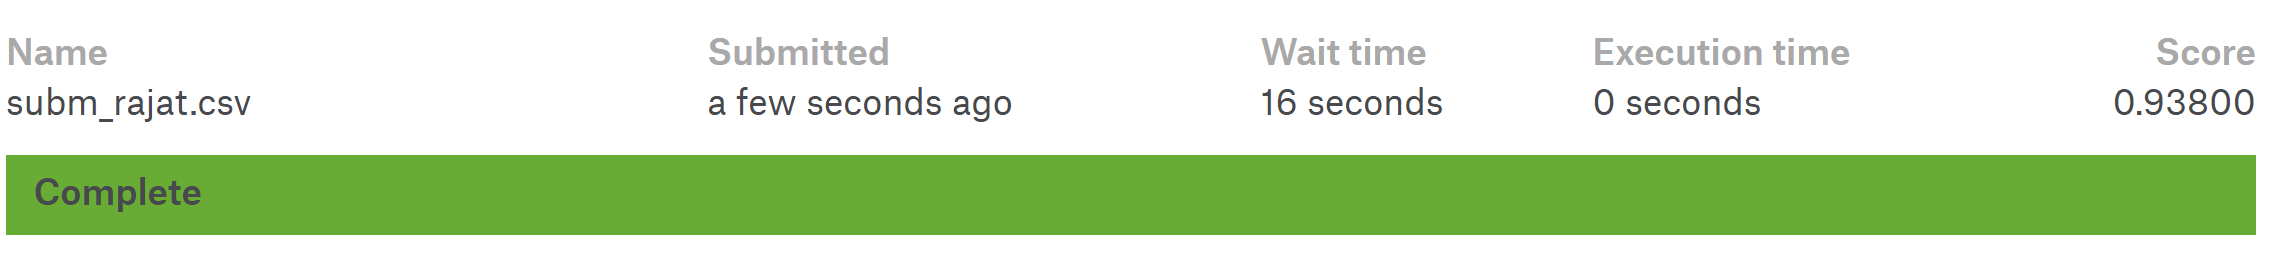